In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

#Cuda 혹은 cpu를 사용하시오.
############Write Your Code Here############
device = 'cuda'
############################################

#Custom_Dataset을 정의하시오.(10점)
class Custom_Dataset(Dataset):
    def __init__(self, X, y):
        #입력으로 들어온 X의 pixel값들을 0-1사이로 normalize하고 X의 shape을 (FB,C,H,W)로 변경하여 저장하여 self.X,self.y에 저장하시오.
        self.X = None
        self.y = None
        ############Write Your Code Here############
        self.X = X/255 #픽셀 255로 나눠 정규화
        self.y = y
        self.X= np.transpose(self.X,(0,3,1,2)) # 채널이 2번째로 오도록 transpose
        ############################################
        
    def __len__(self):
        #Custom_Dataset에 저장되어있는 총 data의 개수를 result에 저장하여 반환하시오.
        result = 0
        ############Write Your Code Here############
        result = len(self.X)
        ############################################
        return result
    
    def __getitem__(self, idx):
        #self.X, self.y 에서 idx에 맞는 data를 result_X,result_y에 저장하여 반환하시오.
        result_X,result_y = None,None
        ############Write Your Code Here############
        result_X = self.X[idx]
        result_y = self.y[idx]
        ############################################
        return result_X,result_y
#torch.nn을 사용하여 아래 함수들을 작성하시오. result는 nn.Layer중 하나이고 result를 반환함.(20점)
def batch_norm(dim,for_MLP=True):
    #for_MLP가 True일 시 MLP를 위한 BN Layer를 반환하고 False일 시 CNN을 위한 BN Layer를 반환함.
    ############Write Your Code Here############
    if for_MLP:
      result = nn.BatchNorm1d(dim)
    else:
      result = nn.BatchNorm2d(dim)
    ############################################
    return result

def fc_layer(in_dim,out_dim):
    #Fully Connected Layer(Dense Layer)
    ############Write Your Code Here############
    result = nn.Linear(in_dim, out_dim)
    ############################################
    return result

def conv_layer(in_ch,out_ch,kernel_size, stride=1, padding=0):
    #Convolutional Layer for image
    ############Write Your Code Here############
    result = nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride, padding=padding)
    ############################################
    return result

def relu():
    #ReLU function
    ############Write Your Code Here############
    result = nn.ReLU()
    ############################################
    return result

def flatten():
    #Flatten the data
    ############Write Your Code Here############
    result =  nn.Flatten()
    ############################################
    return result


#skip_connection(bn -> relu -> conv -> bn -> relu -> conv)를 따르는 Res_block을 만드시오.
#change_res가 True인 res_block을 통과한 feature map은 resolution이 2배 작아지고 channel의 깊이는 2배로 증가함. ex) 32*8*8 -> 64*4*4
#위의 경우에는 skip_connection의 dimension은 1*1 conv로 맞춰줌.
#change_res가 False인 Res_block을 통과한 feature map은 resolution과 channel의 깊이는 그대로 유지됨. ex) 32*4*4 -> 32*4*4(20점)
class Res_block(nn.Module): 
    def __init__(self, input_channel, change_res):
        super(Res_block,self).__init__()
        self.change_res = change_res
        if change_res:
            ############Write Your Code Here############
            self.input_channel = input_channel
            self.conv1=conv_layer(input_channel,input_channel,3,1,1)
            self.bn1 = batch_norm(input_channel, for_MLP=False)
            
            self.bn2 = batch_norm(input_channel*2, for_MLP=False)
            self.conv2=conv_layer(input_channel,input_channel*2,3,2,1) # 보폭 2배로 하여 사이즈 반으로 줄이기 / output채널은 input 채널 x 2 
            self.conv3 = conv_layer(input_channel,input_channel*2,1,2,0) # 채널 2배 커널사이즈1x1로 하고 보폭2로 하야ㅕ
            self.relu = relu()
            #######################################
        else:
            ############Write Your Code Here############
            self.input_channel = input_channel
            self.conv1=conv_layer(input_channel,input_channel,3,1,1) # 그대로
            self.bn1 = batch_norm(input_channel, for_MLP=False)
            self.conv2=conv_layer(input_channel,input_channel,3,1,1) # 그대로
            self.bn2 = batch_norm(input_channel, for_MLP=False)
            self.relu = relu()
            ############################################
        ############Write Your Code Here############
            
        ############################################
    def forward(self,X):
        #skip_connection(bn -> relu -> conv -> bn -> relu -> conv)를 따르는 Res_block을 만드시오.
        ############Write Your Code Here############
        if self.change_res: 
          skip_connection = self.conv3(X)
          X = self.bn1(X)
          X = self.relu(X)
          X = self.conv1(X)

          X = self.bn1(X)
          X = self.relu(X)
          X = self.conv2(X)
          X = X + skip_connection
          # X = self.relu(X)
        else:
          skip_connection = X
          X = self.bn1(X)
          X = self.relu(X)
          X = self.conv1(X)

          X = self.bn2(X)
          X = self.relu(X)
          X = self.conv2(X)
          X = X + skip_connection
          # X = self.relu(X)
        ############################################
        return X

    
#Skip Connection을 이용하여 20개 이상의 layer를 가지고 테스트 셋에대하여 50% 이상의 성능을 주는 MLP를 만드시오.
#nn.ModuleList를 사용하면 많을 층의 layer를 쌓는데 용이함.(20점)
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP,self).__init__()
        ############Write Your Code Here############
        self.flat = flatten().cuda()
        self.batch = batch_norm(512, for_MLP=True).cuda()
        self.relu = relu().cuda()
        self.fc1 = fc_layer(32*32*3, 512).cuda()
        self.fc2 = fc_layer(512, 512).cuda()
        self.fc3 = fc_layer(512, 256).cuda()
        self.fc4 = fc_layer(256, 10).cuda()
        self.dropout = nn.Dropout(0.25).cuda()
        # self.skip_connection = nn.ModuleList()
        ############################################
    def forward(self,X):
        ############Write Your Code Here############
        X = self.flat(X)
        X = self.fc1(X)
        X = self.batch(X)
        X = self.relu(X)
        for i in range(9):
          skip_connection = X
          X = self.fc2(X)
          X = self.relu(X)
          X = self.fc2(X)
          X = self.relu(X)
          X = self.dropout(X)
          X = skip_connection + X
        ############################################
        X = self.fc3(X)
        X = self.fc4(X)
        return X
        
#Res_Block을 사용하여 테스트 셋에대한 70% 이상의 성능을 주는 CNN 모델을 만드시오.
#flatten전에 nn.AdaptiveAvgPool2d를 사용하면 dimension맞추기가 쉬움.(20점)
class CNN(nn.Module):
    def __init__(self, input_channel, class_number, block_number):
        super(CNN,self).__init__()
        ############Write Your Code Here############
        self.flat = flatten()
        self.relu = relu()
        self.conv1=conv_layer(3,16,3,1,1)
        self.bn1 = batch_norm(16,False)
        self.fc1 = fc_layer(1024, 512).cuda()
        self.fc2 = fc_layer(512, 256).cuda()
        self.fc3 = fc_layer(256, 10).cuda()
        self.pool = nn.AvgPool2d(2, stride=2)
        self.layers_2n=nn.Sequential( #ModuleList로 쌓을 수 있지만, 그냥 Sequential로 직접 ResBlock을 쌓았습니다. 저는 CNN Block num이 5인 것을 선택했기에 그냥 이렇게 구현했습니다.
            Res_block(16,False),
            Res_block(16,False),
            Res_block(16,False),
            Res_block(16,False),
            Res_block(16,False)
        )
        self.layers_4n=nn.Sequential(
            Res_block(16,change_res=True),
            Res_block(32,change_res=False),
            Res_block(32,change_res=False),
            Res_block(32,change_res=False),
            Res_block(32,change_res=False)
        )
        self.layers_6n=nn.Sequential(
          Res_block(32,change_res=True),
          Res_block(64,change_res=False),
          Res_block(64,change_res=False),
          Res_block(64,change_res=False),
          Res_block(64,change_res=False)
        )
        ############################################
    def forward(self,X): 
        ############Write Your Code Here############
        X = self.conv1(X)
        X = self.bn1(X)
        X = self.relu(X)

        X = self.layers_2n(X)
        X = self.layers_4n(X)
        X = self.layers_6n(X)

        X = self.pool(X)
        X = self.flat(X)
        X = self.fc1(X)
        X = self.fc2(X)
        X = self.fc3(X)
        ############################################
        return X

#loader에 있는 모든 data들에 대한 정확도를 구하여 accuracy에 저장하여 accuracy를 return하는 함수를 구현하시오.(10점)
def evaluate(model, loader):
    model.eval()
    accuracy = 0
    total_example = 0
    correct_example = 0
    for data in loader:
        x,y = data
        x = torch.tensor(x, device = device)
        y = torch.tensor(y, device = device)
        ############Write Your Code Here############
        x=x.float()
        output = model(x)
        _, pred = torch.max(output.data,1)
        correct_example += (pred==y).sum().item()
        total_example += y.size(0)
        ############################################
    ############Write Your Code Here############
    accuracy = 100 * correct_example/total_example
    ############################################
    model.train()
    return accuracy

#epoch마다 train_loader에 있는 batch들을 사용하여 모델을 학습하고
#epoch의 마지막 iteration에서는 모델의 validation accuracy를 확인하여 제일 높은 val. acc.를 가진 model을 best_model에 저장하고
#val_acc에는 매 epoch마다 구해진 validation accuracy를 저장하시오.
#running_loss에는 각각의 epoch에서 모든 batch의 loss를 다 더하여 저장하시오.
#모든 epoch의 validation accuracy를 val_acc에 저장하여 best_model과 val_acc를 return하는 함수를 구현하시오.(10점)
def train(model, epoches, train_loader, val_loader, optimizer, criteria):
    best_score = 0
    best_model = None
    batch_len = len(train_loader)
    val_acc = []
    for epoch in range(epoches):
        running_loss = 0
        for i,data in enumerate(train_loader):
            x,y = data
            x = torch.tensor(x, device = device)
            y = torch.tensor(y, device = device)
            ############Write Your Code Here############
            model.eval()
            optimizer.zero_grad()
            x=x.float()
            output = model.forward(x)
            _, pred = torch.max(output.data,1)
            loss = criteria(output, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            model.train()
           ############################################
            #epoch의 마지막 iteration
            if i % batch_len == batch_len-1:
                print(f'{epoch+1}th iteration loss :',running_loss/batch_len)
                running_loss = 0
                ############Write Your Code Here############
                accuracy = evaluate(model,val_loader)
                val_acc.append(accuracy)
                val_acc_tensor = torch.FloatTensor(val_acc)
                if torch.max(val_acc_tensor).item() <= accuracy:
                  best_model = deepcopy(model)
                ############################################
    return best_model, val_acc



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:268: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:269: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1th iteration loss : 1.8328530279266866


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


2th iteration loss : 1.6204756760536252
3th iteration loss : 1.537529246581485
4th iteration loss : 1.48054972908381
5th iteration loss : 1.4315301518306098
6th iteration loss : 1.3884918900097118
7th iteration loss : 1.3555504062291606
8th iteration loss : 1.3206344858154921
9th iteration loss : 1.2869966065182405
10th iteration loss : 1.2618854823319807
11th iteration loss : 1.2274093376401136
12th iteration loss : 1.1964655244137015
13th iteration loss : 1.1611072948521666
14th iteration loss : 1.1399347901039416
15th iteration loss : 1.1093611660820748
16th iteration loss : 1.080193708010037
17th iteration loss : 1.050635342860161
18th iteration loss : 1.02495765670791
19th iteration loss : 0.9957685388262619
20th iteration loss : 0.965103128072246
21th iteration loss : 0.92882837465657
22th iteration loss : 0.9127406099873125
23th iteration loss : 0.8797775272213285
24th iteration loss : 0.8467445062554401
25th iteration loss : 0.8217223916212311
26th iteration loss : 0.7890680647

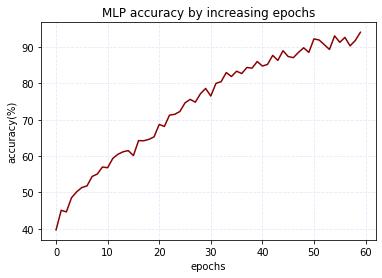

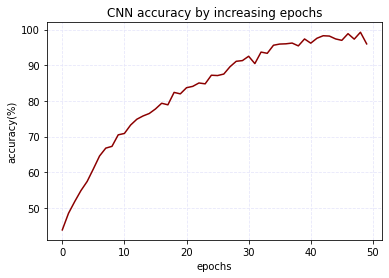

In [2]:
#(50점)
#Read the data
trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True)
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True)

X_train, Y_train = trainset.data, np.array(trainset.targets)
X_test, Y_test = testset.data, np.array(testset.targets)

#앞서 정의한 Custom_Dataset과 DataLoader를 사용하여 train_loader,val_loader,test_loader를 정의하시오.
#Batch_size는 본인의 컴퓨터 사향에 맞게 변경하면 됨. Validation Set으로 Train Set의 20%를 사용함.
#Preprocessing
train_loader = None
val_loader = None
test_loader = None
batch_size = 1
############Write Your Code Here############
Custom_train_data = Custom_Dataset(X_train,Y_train)

from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,y_val = train_test_split(X_train,Y_train,test_size=0.2, stratify=Y_train, random_state=1)
Custom_val_data = Custom_Dataset(X_val,y_val)

Custom_test_data = Custom_Dataset(X_test,Y_test)

train_loader = DataLoader(Custom_train_data,batch_size=128, shuffle=True,num_workers=2)
val_loader = DataLoader(Custom_val_data,batch_size=128, shuffle=True,num_workers=2)
test_loader = DataLoader(Custom_test_data,batch_size=128, shuffle=True,num_workers=2)
############################################

#앞서 정의한 MLP,CNN을 사용하여 mlp_model,cnn_model을 정의하시오.
#Define the model
mlp_model = None
cnn_model = None
############Write Your Code Here############
mlp_model = MLP(32*32*3, 10)
cnn_model = CNN(3,10,5)
############################################
mlp_model.to(device)
cnn_model.to(device)


#앞서 정의한 train함수를 사용하여 best_mlp, mpl_val_acc, best_cnn, cnn_val_acc를 구하시오.
#Train the model
best_mlp = None
mlp_val_acc = None
best_cnn = None
cnn_val_acc = None
############Write Your Code Here############
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.0001)
optimizer2 = torch.optim.Adam(cnn_model.parameters(), lr=0.0001)
best_mlp, mlp_val_acc = train(mlp_model, 60, train_loader, val_loader, optimizer, nn.CrossEntropyLoss())
best_cnn, cnn_val_acc = train(cnn_model, 50, train_loader, val_loader, optimizer2, nn.CrossEntropyLoss())
############################################


#앞서 정의한 evaluate함수와 best_model들을 사용하여 mlp_acc, cnn_acc를 구하시오.
#Test Accuracy
mlp_acc = None  
cnn_acc = None 
############Write Your Code Here############
mlp_acc = evaluate(best_mlp,test_loader)
cnn_acc = evaluate(best_cnn,test_loader)
############################################
print('MLP accuracy:',mlp_acc)
print('CNN accuracy:',cnn_acc)
############################################

#앞서 구한 val_acc들을 사용하여 이해 가능한 그래프를 그리시오.
#Validation Accuracy Plot
############Write Your Code Here############
fig = plt.figure()
# 정확도 그래프 그리기
plt.plot(range(60),mlp_val_acc, label='Accuracy', color='darkred')
# 축 이름
plt.xlabel('epochs')
plt.ylabel('accuracy(%)')
plt.title('MLP accuracy by increasing epochs')
plt.grid(linestyle='--', color='lavender')
# 그래프 표시
plt.show()



fig = plt.figure()
# 정확도 그래프 그리기
plt.plot(range(50),cnn_val_acc, label='Accuracy', color='darkred')
# 축 이름
plt.xlabel('epochs')
plt.ylabel('accuracy(%)')
plt.title('CNN accuracy by increasing epochs')
plt.grid(linestyle='--', color='lavender')
# 그래프 표시
plt.show()
############################################